<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# W state in multi-qubit systems

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
## Contributors

Pierre Decoodt, Université Libre de Bruxelles

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception('Please use Python version 3 or greater.')
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
from pprint import pprint

# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram 
#import Qconfig 
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
QPS_SPECS = {
    'circuits': [{
        'name': 'W_states',
        'quantum_registers': [{
            'name':'q',
            'size':5
        }],
        'classical_registers': [{
            'name':'c',
            'size':5
        }]}],
}
Q_program = QuantumProgram(specs=QPS_SPECS)
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])  

## Theoretical background

In addition to the GHZ states, the generalized W states, as proposed by Dür, Vidal and Cirac, in 2000, is a class of interesting examples of multiple qubit entanglement.

A generalized $n$ qubit W state can be written as :
$$ |W_{n}\rangle \; = \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |01...0\rangle \: +...+ |00...1\rangle \:) $$

Here are presented circuits allowing to deterministically produce respectively a three, a four and a five qubit W state.

A 2016 paper by Firat Diker proposes an algorithm in the form of nested boxes allowing the deterministic construction of W states of any size $n$. The experimental setup proposed by the author is essentially an optical assembly including half-wave plates. The setup includes $n-1$ so-called two-qubit $F$ gates (not to be confounded with the Fredkin's three-qubit gate).

It is possible to construct the equivalent of such a $F$ gate on a superconducting quantum computing system using transmon qubits in ground and excited states. A $F_{k,\, k+1}$ gate with control qubit $q_{k}$ and target qubit $q_{k+1}$ is obtained here by:

 - First a rotation round Y-axis $R_{y}(-\theta_{k})$ applied on $q_{k+1}$
 - Then a controlled Z-gate $cZ$ in any direction between the two qubits $q_{k}$ and $q_{k+1}$
 - Finally a rotation round Y-axis $R_{y}(\theta_{k})$ applied on $q_{k+1}$
 
The matrix representations of a $R_{y}(\theta)$ rotation and of the $cZ$ gate can be found in the "Quantum gates and linear algebra" Jupyter notebook of the QISKit tutorial. 

The value of $\theta_{k}$ depends on $n$ and $k$ following the relationship:

$$\theta_{k} = \arccos \left(\sqrt{\frac{1}{n-k+1}}\right) $$

Note that this formula for $\theta$ is different from the one mentioned in the Diker's paper. This is due to the fact that we use here Y-axis rotation matrices instead of $W$ optical gates composed of half-wave plates.

At the beginning, the qubits are placed in the state:  $|\varphi_{0} \rangle \, = \, |10...0 \rangle$.

This is followed by the application of $n-1$ sucessive $F$ gates. 

$$|\varphi_{1}\rangle = F_{n-1,\,n}\, ... \, F_{k,\, k+1}\, ... \, F_{2,\, 3}  \,F_{1,\, 2}\,|\varphi_{0} \rangle \,= \; \sqrt{\frac{1}{n}} \: (\:|10...0\rangle \: +  |11...0\rangle \: +...+ |11...1\rangle \:) $$

Then, $n-1$ $cNOT$ gates are applied. The final circuit is: 

$$|W_{n}\rangle \,= cNOT_{n,\, n-1}\, cNOT_{n-1,\, n-2}...cNOT_{k,\, k-1}...cNOT_{2,\, 1}\,\,|\varphi_{1} \rangle$$

Let's launch now in the adventure of producing deterministically W states, on simulator or in the real world!

Now you will have the opportunity to choose your backend.

(If you run the following cells in sequence, you will end with the local simulator, which is a good choice for a first trial).

In [3]:
"Choice of the backend"
# The flag_qx2 must be "True" for using the ibmqx2. 
# "True" is also better when using the simulator (shorter circuit)
#backend = 'ibmqx2'
#backend = 'ibmqx4'
backend = 'local_qasm_simulator'  

#backend = 'ibmqx_hpc_qasm_simulator'  
flag_qx2 = True
if backend == 'ibmqx4':
        flag_qx2 = False
        
print("Your choice for the backend is: ", backend, "flag_qx2 is: ", flag_qx2)

Your choice for the backend is:  local_qiskit_simulator flag_qx2 is:  True


In [4]:
# Here, two useful routine
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])

## Three-qubit W state, step 1

In this section, the production of a three qubit W state will be examined step by step.

In this circuit, the starting state is now: $ |\varphi_{0} \rangle \, = \, |100\rangle$.

The entire circuit corresponds to:                                 
                
$$ |W_{3}\rangle \,=\,  cNOT_{3,2}\,  \, cNOT_{2,1}\,  \, F_{2,3} \, 
\, F_{1,2} \,  \, |\varphi_{0} \rangle \, $$    

Run the following cell to see what happens when we first apply $F_{1,2}$.

start W state 3-qubit (step 1) on local_qiskit_simulator N= 1024 03/04/2018 09:24:36
end   W state 3-qubit (step 1) on local_qiskit_simulator N= 1024 03/04/2018 09:24:36


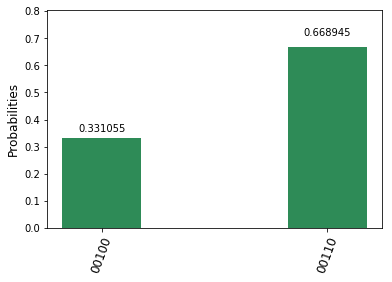

In [6]:
# 3-qubit W state Step 1

Q_program = QuantumProgram(specs=QPS_SPECS)
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])  
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')

W_states.x(q[2]) #start is |100>
F_gate(W_states,q,2,1,3,1) # Applying F12
    
for i in range(3) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3-qubit (step 1) on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, timeout=600)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3-qubit (step 1) on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

## Three-qubit W state: adding step 2

In the previous step you obtained an histogram compatible with the following state:

$$ |\varphi_{1} \rangle= F_{1,2}\,  |\varphi_{0} \rangle\,=F_{1,2}\,  \,|1 0 0 \rangle=\frac{1}{\sqrt{3}} \: |1 0 0 \rangle \: + \sqrt{\frac{2}{3}} \: |1 1 0 \rangle $$

NB: Depending on the backend, it happens that the order of the qubits is modified, but without consequence for the state finally reached.

We seem far from the ultimate goal.

Run the following circuit to obtain $|\varphi_{2} \rangle =F_{2,3}\, \, |\varphi_{1} \rangle$

start W state 3-qubit (steps 1 + 2) on local_qiskit_simulator N= 1024 03/04/2018 09:25:18
end   W state 3-qubit (steps 1 + 2) on local_qiskit_simulator N= 1024 03/04/2018 09:25:19


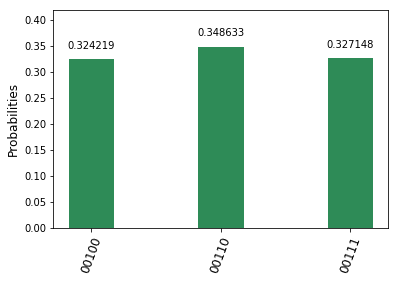

In [7]:
# 3-qubit W state, first and second steps

Q_program = QuantumProgram(specs=QPS_SPECS)
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])  
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')
        

W_states.x(q[2]) #start is |100>
F_gate(W_states,q,2,1,3,1) # Applying F12
F_gate(W_states,q,1,0,3,2) # Applying F23
       
for i in range(3) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3-qubit (steps 1 + 2) on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5, timeout=600)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3-qubit (steps 1 + 2) on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

## Three-qubit W state, full circuit

In the previous step, we got an histogram compatible with the state:

$$ |\varphi_{2} \rangle =F_{2,3}\,  \, |\varphi_{1} \rangle=F_{2,3}\,  \, (\frac{1}{\sqrt{3}} \: |1 0 0 \rangle \: + \sqrt{\frac{2}{3}} \: |1 1 0 )= \frac{1}{\sqrt{3}} \: (|1 0 0 \rangle \: +  |1 1 0 \:\rangle +  |1 1 1\rangle) $$

NB: Again, depending on the backend, it happens that the order of the qubits is modified, but without consequence for the state finally reached.

It looks like we are nearing the goal.

Indeed, two $cNOT$ gates will make it possible to create a W state.

Run the following cell to see what happens. Did we succeed?

start W state 3-qubit on local_qiskit_simulator N= 1024 03/04/2018 09:25:46
end   W state 3-qubit on local_qiskit_simulator N= 1024 03/04/2018 09:25:46


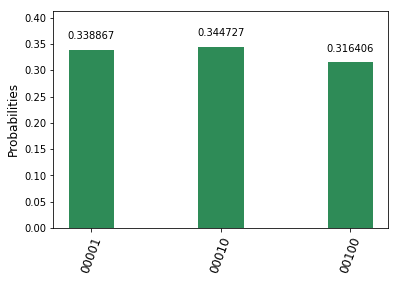

In [8]:
# 3-qubit W state

Q_program = QuantumProgram(specs=QPS_SPECS)
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])   
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')

W_states.x(q[2]) #start is |100>
F_gate(W_states,q,2,1,3,1) # Applying F12
F_gate(W_states,q,1,0,3,2) # Applying F23

if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 21
    W_states.cx(q[0],q[1]) # cNOT 32
    
else :        # option ibmqx4  
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(3) :
    W_states.measure(q[i] , c[i]) 
    
circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 3-qubit on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5,  timeout=600)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 3-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now you get an histogram compatible with the final state $|W_{3}\rangle$ through the following steps:

$$ |\varphi_{3} \rangle =  cNOT_{2,1}\,  \, |\varphi_{2} \rangle =cNOT_{2,1}\,\frac{1}{\sqrt{3}} \: (|1 0 0 \rangle \: +  |1 1 0 \rangle\: +  |1 1 1\rangle)  =  \frac{1}{\sqrt{3}} \: (|1 0 0 \rangle \: +  |0 1 0 \: +  |0 1 1\rangle) $$

$$ |W_{3} \rangle =  cNOT_{3,2}\, \, |\varphi_{3} \rangle =cNOT_{3,2}\,\frac{1}{\sqrt{3}} \: (|1 0 0 \rangle \: +  |010 \: \rangle+  |0 1 1\rangle)  =  \frac{1}{\sqrt{3}} \: (|1 0 0 \rangle \: +  |0 1 0 \: +  |0 0 1\rangle) $$

Bingo!

## Four-qubit W state

In this section, the production of a four-qubit W state will be obtained by extending the previous circuit.

In this circuit, the starting state is now: $ |\varphi_{0} \rangle \, = \, |1000\rangle$.

A $F$ gate was added at the beginning of the circuit and a $cNOT$ gate was added before the measurement phase.

The entire circuit corresponds to:

$$ |W_{4}\rangle \,=\, cNOT_{4,3}\,  \, cNOT_{3,2}\,  \, cNOT_{2,1}\,  \, F_{3,4} \, \, F_{2,3} \,  \, F_{1,2} \,  \,|\varphi_{0} \rangle \, $$  

Run the following circuit and see what happens.

start W state 4-qubit  local_qiskit_simulator N= 1024 03/04/2018 09:26:01
end   W state 4-qubit on local_qiskit_simulator N= 1024 03/04/2018 09:26:01


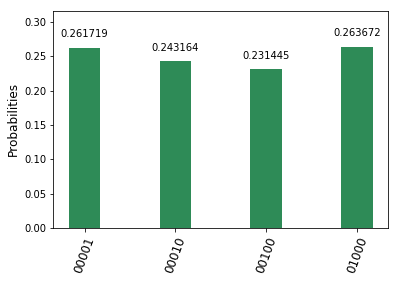

In [9]:
# 4-qubit W state

Q_program = QuantumProgram(specs=QPS_SPECS)
# Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])  
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')

W_states.x(q[3]) #start is |1000>
F_gate(W_states,q,3,2,4,1) # Applying F12
F_gate(W_states,q,2,1,4,2) # Applying F23
F_gate(W_states,q,1,0,4,3) # Applying F34        
cxrv(W_states,q,2,3) # cNOT 21
if flag_qx2 : # option ibmqx2  
    W_states.cx(q[1],q[2]) # cNOT 32
    W_states.cx(q[0],q[1]) # cNOT 43

else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)

for i in range(4) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 4-qubit ', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5,  timeout=600)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 4-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now, if you used a simulator, you get an histogram clearly compatible with the state:

$$ |W_{4}\rangle \;=\; \frac{1}{2} \: (\:|1000\rangle  +  |0100\rangle  + |0010\rangle + |0001\rangle \:) $$

If you used a real quantum computer, the columns of the histogram compatible with a $|W_{4}\rangle$ state are not all among the highest one. Errors are spreading...

## Five-qubit W state

In this section, a five-qubit W state will be obtained, again by extending the previous circuit.

In this circuit, the starting state is now: $ |\varphi_{0} \rangle  =  |10000\rangle$.

A $F$ gate was added at the beginning of the circuit and an additionnal $cNOT$ gate was added before the measurement phase.

$$ |W_{5}\rangle = cNOT_{5,4}   cNOT_{4,3}   cNOT_{3,2}   cNOT_{2,1}  F_{4,5}   F_{3,4}   F_{2,3}    F_{1,2}   |\varphi_{0} \rangle  $$

Run the following cell and see what happens.

start W state 5-qubit on local_qiskit_simulator N= 1024 03/04/2018 09:26:17
end   W state 5-qubit on local_qiskit_simulator N= 1024 03/04/2018 09:26:18


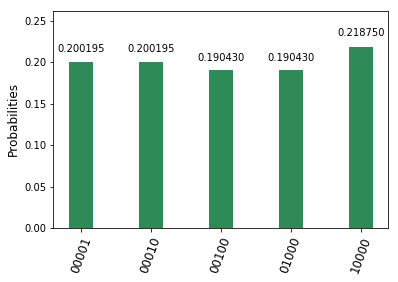

In [10]:
# 5-qubit W state

Q_program = QuantumProgram(specs=QPS_SPECS)
#Q_program.set_api(Qconfig.APItoken, Qconfig.config['url'])  
W_states = Q_program.get_circuit('W_states') 
q = Q_program.get_quantum_register('q') 
c = Q_program.get_classical_register('c')

W_states.x(q[4]) #start is |10000>
F_gate(W_states,q,4,3,5,1) # Applying F12
F_gate(W_states,q,3,2,5,2) # Applying F23
F_gate(W_states,q,2,1,5,3) # Applying F34
F_gate(W_states,q,1,0,5,4) # Applying F45
W_states.cx(q[3],q[4]) # cNOT 21
cxrv(W_states,q,2,3)   # cNOT 32
if flag_qx2 : # option ibmqx2 
    W_states.cx(q[1],q[2]) # cNOT 43
    W_states.cx(q[0],q[1]) # cNOT 54
    
else :        # option ibmqx4 
    cxrv(W_states,q,1,2)
    cxrv(W_states,q,0,1)     
    
for i in range(5) :
    W_states.measure(q[i] , c[i]) 

circuits = ['W_states']

shots = 1024
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('start W state 5-qubit on', backend, "N=", shots,time_exp)
result = Q_program.execute(circuits, backend=backend, shots=shots, max_credits=5,  timeout=1200)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print('end   W state 5-qubit on', backend, "N=", shots,time_exp)
plot_histogram(result.get_counts('W_states'))

Now, if you used the simulator, you see an histogram compatible with the state:

$$|W_{5}\rangle=\frac{1}{\sqrt{5}}\:(\:|10000\rangle  +  |01000\rangle  + |00100\rangle +|00010\rangle\  +|00001\rangle)$$

But if you were running the program on one of the available real quantum computers, things are still less clear than in the previous case.

## Conclusion:

When the quantum computer simulator is used, the results accurately reflect the expected spectrum of frequency corresponding to a given $n$ value.

For $n = 3$ on a real quantum computer, the results are obviously in accordance with W states.

The errors amplify significantly for higher $n$ values, but the histogram shows the persistence of some frequency peaks compatible with W states creation.

One cause of errors is the increasing number of gates. Even for an ideal quantum computer, where all the qubits are connected together bidirectionally, the number of elementary gates necessary for building the $F$ gates increases linearly with n, just like the number of late $cNOT$ in this model. Another cause of error is the interval between successive values of $\theta_{k}$. Indeed these intervals decreases significantly for lower $k$ as $n$ increases.


## Mathematical appendix :

The operator allowing to deterministically obtain a n-qubit W state from the starting state $\, |00...0 \rangle$ can be coined a $W_{n}$ gate.

For a three-qubit W state, the equation in Dirac notation is:

$$W_{3}\;\, |000 \rangle=\sqrt{\frac{1}{3}}(|100\rangle + |010\rangle + |001\rangle)$$

which becomes in matrix notation:

$$\begin{pmatrix}0 & 0 & 0 & 0 & \;\;1\;\; & 0 & 0 & 0\\\sqrt{\frac{1}{3}} & -\sqrt{\frac{1}{3}} & -\sqrt{\frac{1}{6}} & \sqrt{\frac{1}{6}} & 0 & 0 & 0 & 0\\\sqrt{\frac{1}{3}} & \sqrt{\frac{1}{3}} & -\sqrt{\frac{1}{6}} & -\sqrt{\frac{1}{6}} & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & \;\;1\;\; & 0 & 0\\\sqrt{\frac{1}{3}} & 0 & \sqrt{\frac{2}{3}}
 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & \sqrt{\frac{1}{2}}
 & -\sqrt{\frac{1}{2}}\\0 & 0 & 0 & 0 & 0 & 0 & \sqrt{\frac{1}{2}} & \sqrt{\frac{1}{2}}\\0 & \sqrt{\frac{1}{3}} & 0 & \sqrt{\frac{2}{3}}
 & 0 & 0 & 0 & 0\end{pmatrix} \;
 \begin{pmatrix}1\\0\\0\\0\\0\\0\\0\\0\end{pmatrix} = 
 \begin{pmatrix}0\\\sqrt{\frac{1}{3}}\\\sqrt{\frac{1}{3}}\\0\\\sqrt{\frac{1}{3}}\\0\\0\\0\end{pmatrix}$$
 
 One can easily verify that:
 
 $$W_{3}^{\dagger}W_{3} = I$$
 
 and that there is reversibility:
 
 $$W_{3}^{\dagger}\;\, \sqrt{\frac{1}{3}}(|100\rangle + |010\rangle + |001\rangle) = |000 \rangle$$